In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for job 2
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [5]:
# Filter the dataset to keep only the selected columns, verifying they exist
data = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)

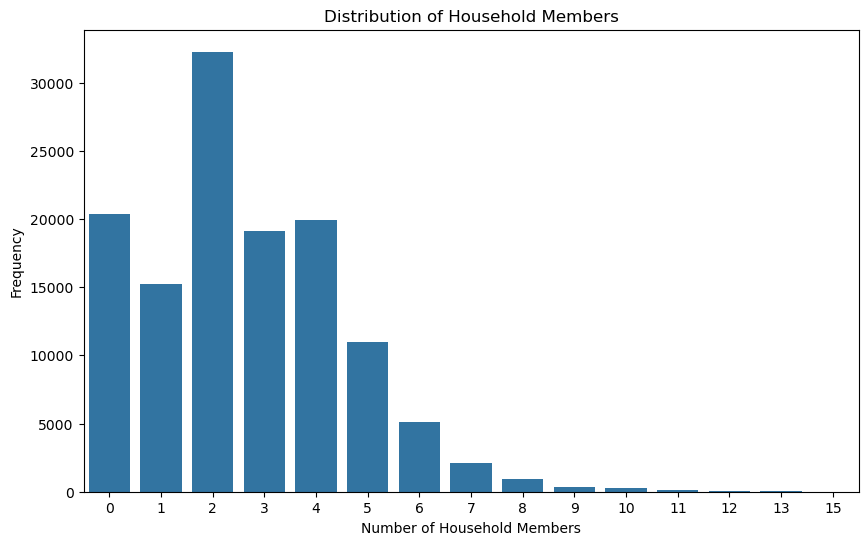

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove any leading/trailing whitespace characters in column names
data.columns = data.columns.str.strip()

# Plotting using seaborn's countplot for discrete values (if feasible)
plt.figure(figsize=(10, 6))
sns.countplot(x='household_members', data=data)
plt.title('Distribution of Household Members')
plt.xlabel('Number of Household Members')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Impute -1 in Family income with weekly earning values when family income is -1
data.loc[(data['weekly_earnings'] != -1) & (data['family_income'] == -1), 'family_income'] = data['weekly_earnings']

In [9]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [10]:
data.corr()

,household_members,family_income,highest_level_of_school,education_level,professional_certification1,cert_issued_by_state_or_gov,is_cert_required,employment_status,primary_industry_code_job1,industry_code_job1,...,total_hours_worked,weekly_earnings,race,age,gender,citizenship_status,state_code,usual_hours_worked,reason_for_unemployment,health_status_impacting_work
household_members,1.000000,0.547456,0.147081,0.181587,0.188781,0.045012,0.049557,0.126980,0.146302,0.145870,...,0.002044,0.037416,0.392160,0.057427,0.500987,0.424425,-0.016181,0.140063,0.038576,0.498133
family_income,0.547456,1.000000,0.108048,0.625957,0.577908,0.229165,0.220739,0.336488,0.409742,0.414664,...,0.023287,0.156648,0.525560,0.518597,0.788467,0.575909,-0.012196,0.426738,0.021515,0.847197
highest_level_of_school,0.147081,0.108048,1.000000,0.160567,0.185743,-0.016332,-0.016671,0.244464,0.060434,0.061488,...,-0.004323,-0.021227,0.103742,-0.086115,0.123900,0.076899,-0.007762,-0.033241,0.038939,0.114297
education_level,0.181587,0.625957,0.160567,1.000000,0.957978,0.278930,0.257289,0.676103,0.531099,0.536556,...,0.024401,0.171741,0.398851,0.813698,0.667594,0.548853,-0.015153,0.520503,0.078996,0.709779
professional_certification1,0.188781,0.577908,0.185743,0.957978,1.000000,0.040038,0.036878,0.727126,0.447204,0.453837,...,0.014707,0.130831,0.392924,0.793313,0.649998,0.554577,-0.017120,0.445727,0.088025,0.683755
cert_issued_by_state_or_gov,0.045012,0.229165,-0.016332,0.278930,0.040038,1.000000,0.905661,0.010098,0.363871,0.356528,...,0.032120,0.142496,0.089930,0.188083,0.178438,0.106266,0.010132,0.330226,-0.002176,0.194902
is_cert_required,0.049557,0.220739,-0.016671,0.257289,0.036878,0.905661,1.000000,-0.060018,0.411306,0.404202,...,0.034438,0.158358,0.083090,0.151950,0.163839,0.098958,0.012204,0.379798,0.003435,0.178639
employment_status,0.126980,0.336488,0.244464,0.676103,0.727126,0.010098,-0.060018,1.000000,-0.106770,-0.107565,...,-0.006346,-0.045612,0.287030,0.639433,0.496211,0.380355,-0.021714,-0.145115,0.098682,0.499006
primary_industry_code_job1,0.146302,0.409742,0.060434,0.531099,0.447204,0.363871,0.411306,-0.106770,1.000000,0.982882,...,0.035875,0.236459,0.219200,0.273325,0.355475,0.297602,-0.002629,0.735263,0.091680,0.357422
industry_code_job1,0.145870,0.414664,0.061488,0.536556,0.453837,0.356528,0.404202,-0.107565,0.982882,1.000000,...,0.035485,0.241148,0.222962,0.275944,0.359551,0.299731,-0.003178,0.741997,0.093795,0.362050


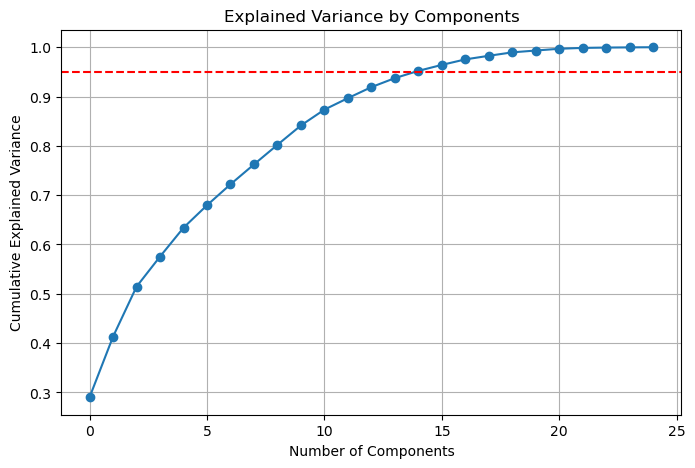

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd



# Scaling the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)

pca = PCA().fit(df_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line at 95% variance
plt.show()

In [13]:
# Using the PCA fit from before
eigenvalues = pca.explained_variance_
print("Eigenvalues:\n", eigenvalues)
num_components_kaiser = np.sum(eigenvalues > 1)
print("Number of Components with Eigenvalues > 1:", num_components_kaiser)

Eigenvalues:
 [7.25549878 3.07337937 2.53347891 1.52479987 1.46267913 1.13846985
 1.06200268 1.00790005 0.99521683 0.98060043 0.80370272 0.58060109
 0.55985321 0.45625654 0.36708027 0.30279641 0.27938096 0.18195316
 0.17473396 0.09232661 0.08952628 0.04360145 0.01685776 0.00978772
 0.00771315]
Number of Components with Eigenvalues > 1: 8


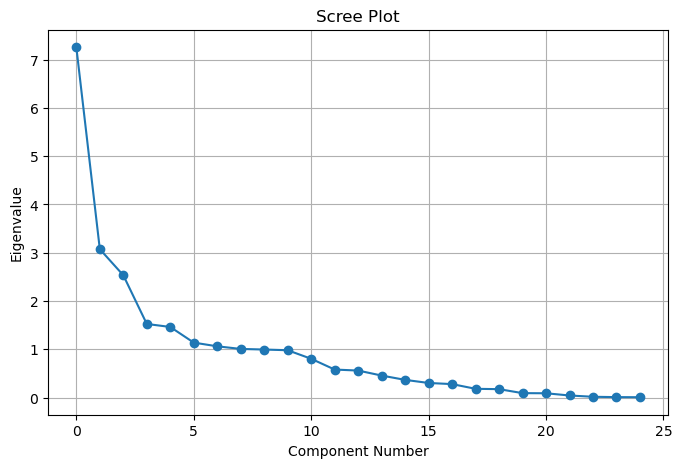

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(eigenvalues, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [15]:
# Applying PCA
pca = PCA(n_components=10)  
principal_components = pca.fit_transform(df_scaled)

# Examine component loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data.columns)
print("Loadings:\n", loading_matrix)

Loadings:
                                    PC1       PC2       PC3       PC4  \
household_members             0.425887 -0.173110  0.078282  0.717471   
family_income                 0.815156 -0.138872  0.040228  0.307940   
highest_level_of_school       0.141898 -0.138115  0.089814  0.093671   
education_level               0.897413 -0.117233  0.025854 -0.372891   
professional_certification1   0.841659 -0.245670  0.102849 -0.370159   
cert_issued_by_state_or_gov   0.356376  0.436667 -0.277491 -0.075988   
is_cert_required              0.356283  0.494644 -0.305003 -0.046690   
employment_status             0.481408 -0.587767  0.331407 -0.404734   
primary_industry_code_job1    0.657594  0.503636 -0.339841 -0.014949   
industry_code_job1            0.662401  0.502144 -0.339801 -0.014929   
occupation_code_job1          0.526635  0.345678 -0.267464 -0.005810   
primary_industry_code_job2    0.110441  0.555442  0.789061  0.003247   
industry_code_job2            0.111268  0.558719  0.7

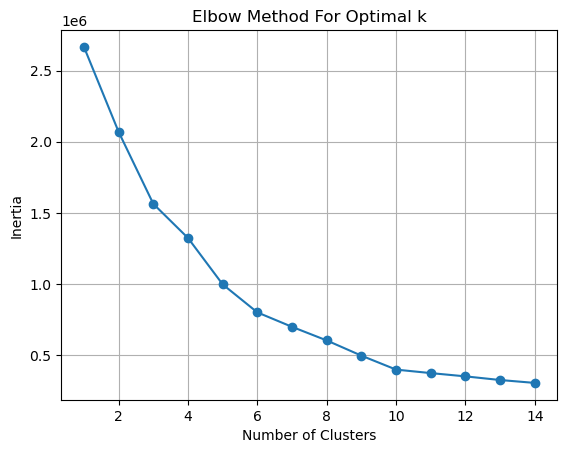

In [16]:
inertia = []
range_values = range(1, 15)  # Testing 1-14 clusters

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

plt.plot(range_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [17]:
# optimal_k is the chosen number of clusters
optimal_k = 6  # k chosen from the elbow method 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(principal_components)

#  these cluster labels to your original or reduced DataFrame for further analysis
data['Cluster'] = clusters 

Cluster centers:
         PC1        PC2        PC3       PC4       PC5       PC6       PC7  \
0 -1.288033  -0.593736   0.338365  2.503935  0.468512  0.378948 -0.243363   
1  2.161155   0.422309  -0.588499  0.028331 -1.418078  0.050632 -0.063683   
2  0.865139  -2.017539   1.098131 -0.805166  0.558208 -0.004839  0.103957   
3 -4.489314   0.911824  -0.344157 -0.521775 -0.164787 -0.114643  0.083863   
4  4.353902  14.131760  18.228670  0.045203 -0.035910 -0.459734 -0.503253   
5  2.968136   2.426322  -1.919269 -0.179630  2.515116 -0.395993  0.081113   

        PC8       PC9      PC10  
0 -0.080278  0.021535 -0.356424  
1 -0.017221  0.021748  0.001908  
2 -0.002709  0.003082  0.117332  
3  0.052896 -0.019647  0.079350  
4 -0.088004 -0.305440 -0.133380  
5  0.057283 -0.045423 -0.005894  


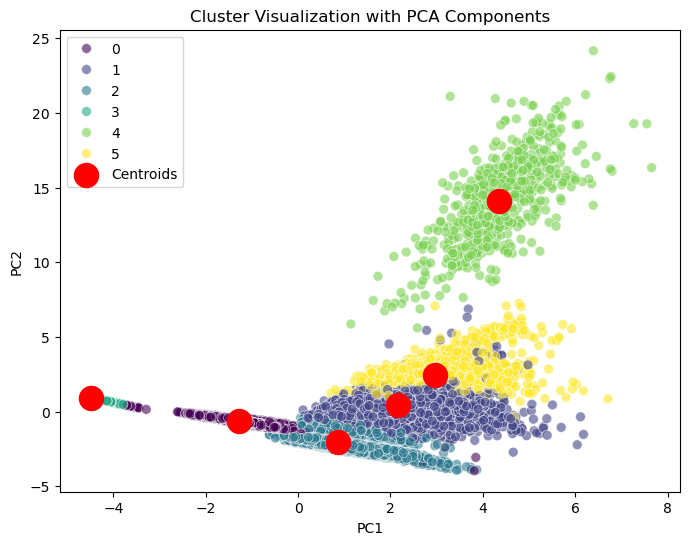

In [18]:
# Viewing cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(10)])
print("Cluster centers:\n", centers)

# Visualizing clusters (if reduced to 2 or 3 dimensions earlier)
import seaborn as sns
if principal_components.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.6)
    plt.scatter(centers.iloc[:, 0], centers.iloc[:, 1], s=300, c='red', label='Centroids')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Cluster Visualization with PCA Components')
    plt.legend()
    plt.show()

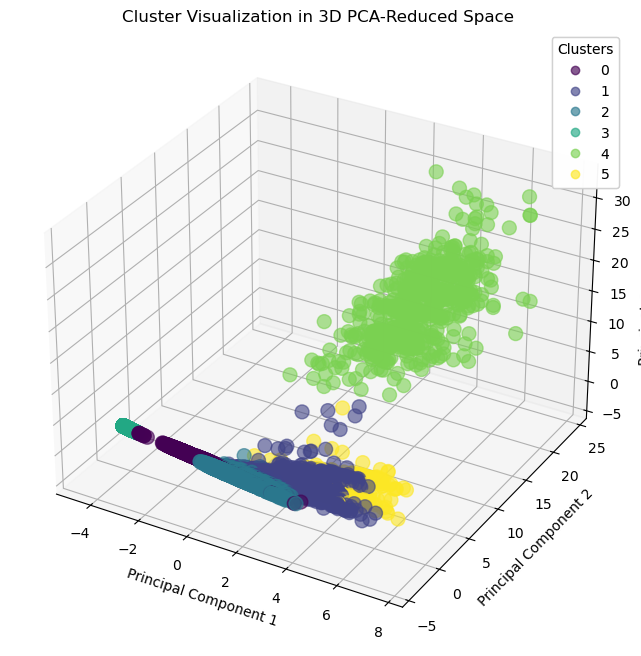

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=clusters, cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Cluster Visualization in 3D PCA-Reduced Space')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()

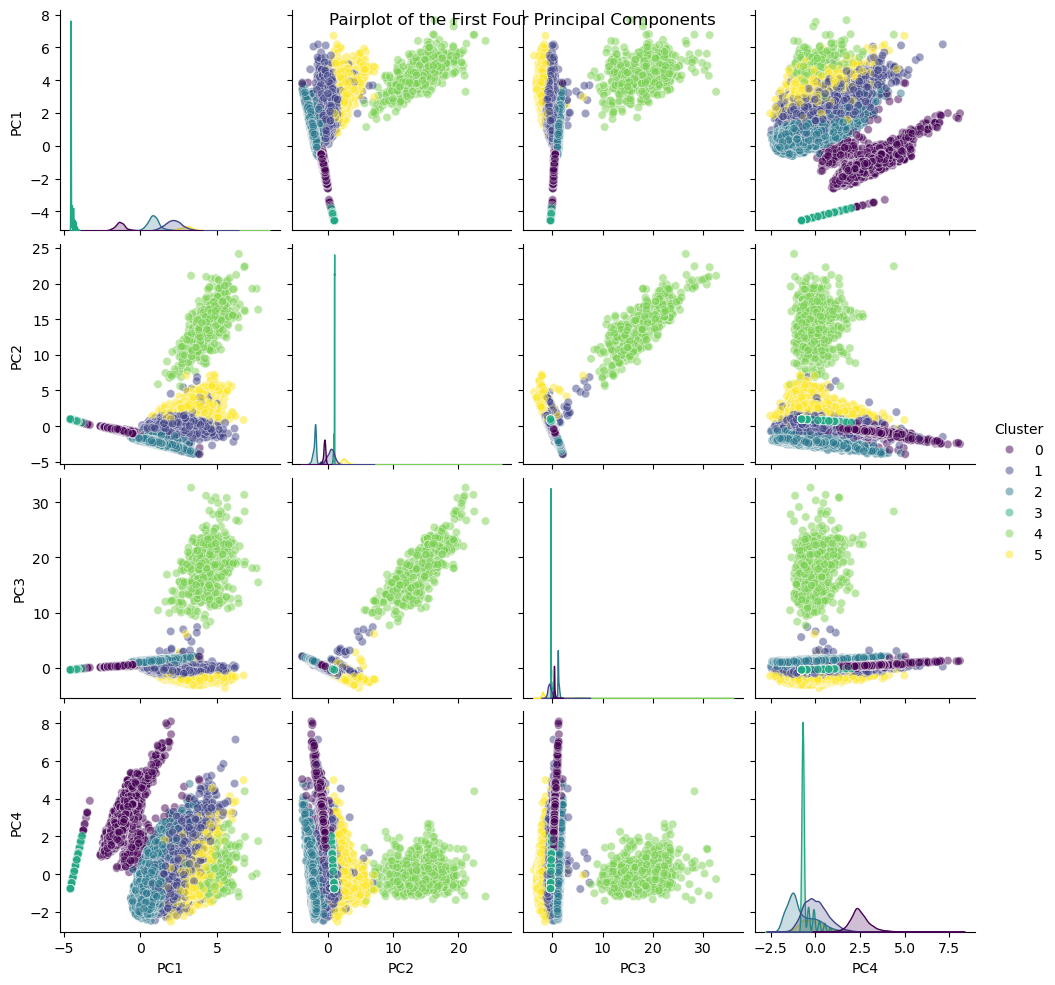

In [20]:
# Create a DataFrame with the first few principal components and cluster labels
pca_df = pd.DataFrame(data=principal_components[:, :4], columns=[f'PC{i+1}' for i in range(4)])
pca_df['Cluster'] = clusters

sns.pairplot(pca_df, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of the First Four Principal Components', verticalalignment='top')
plt.show()

In [25]:
from sklearn.metrics import silhouette_score

filtered_labels = clusters[clusters != -1]
filtered_embedding = principal_components[clusters != -1]

# Calculate the silhouette score
score = silhouette_score(filtered_embedding, filtered_labels)
print('Silhouette Score: ', score)

Silhouette Score:  0.5298237816991197
